In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from nilearn.glm.first_level import glover_hrf
main_path = "/jukebox/PNI-classes/students/NEU502/2023-NEU502B/wlong/multilang/"
fig_path = "../../figures"
subject_name = "S1"

<StemContainer object of 3 artists>

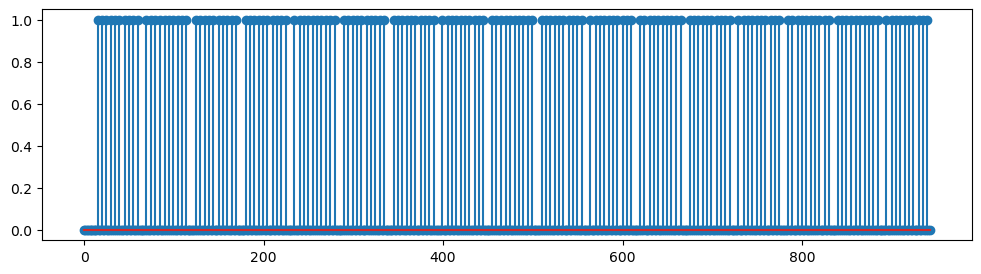

In [2]:
tr = 1.5
n_trs = 630
time = np.arange(0, n_trs*tr, tr)

# load stimulus data
stim_df = pd.read_csv(os.path.join(main_path, 'stimulus_record/780929_502b_project_code_edited_2023-04-05_13h44.30.136.csv'))
t_scan_start = stim_df['key_resp.started'][0] + stim_df['key_resp.rt'][0]
stim_df.Language = stim_df.Language.str.split('_', expand=True).to_numpy()
stim_df.stimFile = stim_df.stimFile.str.split('/|_', expand=True).to_numpy()
stim_df.StimFile = stim_df.StimFile.str.split('/|_', expand=True).to_numpy()
stim_df['word'] = stim_df.stimFile

stim_df.loc[stim_df.word.isnull(), 'word'] = stim_df.loc[stim_df.word.isnull(), 'StimFile']
stim_df = stim_df[~stim_df.word.isnull()].reset_index(drop=True)

stim_trs, _ = np.histogram(stim_df['Sound.started']-t_scan_start, bins=time)  # stims binned into TRs (have not adjusted for if they are presented right at the end of a TR)

fig, ax = plt.subplots(figsize=(12, 3))
ax.stem(time[: n_trs - 1], stim_trs)

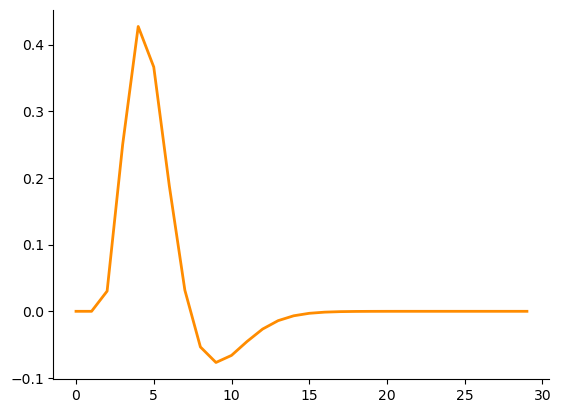

In [3]:
hrf = glover_hrf(tr, time_length = 45, oversampling = 1)
plt.plot(hrf, c='darkorange', lw = 2)
sns.despine()

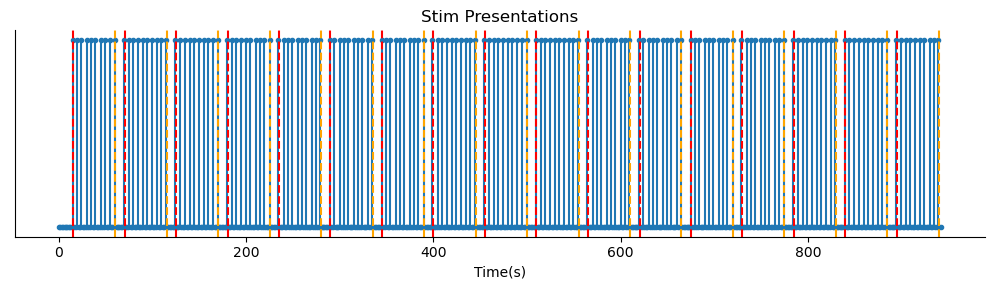

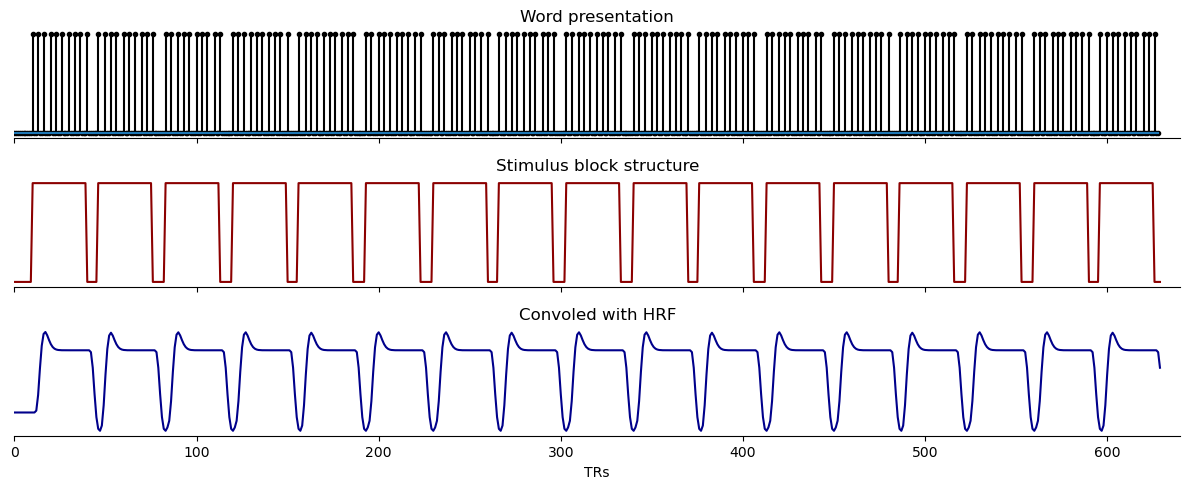

In [32]:
import matplotlib

matplotlib.rcParams['axes.spines.left'] = False
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False

## Detecting start and end time
stim_start = stim_df['Sound.started'].to_numpy() - t_scan_start
block_start_indices = np.where(np.diff(stim_start) > 5.5)[0]
## Total switches: (3 session * 6 languages) - 1 = 17
assert len(block_start_indices) == 17 

block_end_time = stim_start[block_start_indices]
iti_interval = stim_start[block_start_indices + 1] - stim_start[block_start_indices]
block_start_time = (block_end_time + iti_interval)[:-1]
## Insert first stim start at the beginning
block_start_time = np.insert(block_start_time, 0, stim_start[0])
duration = block_end_time - block_start_time

fig, ax = plt.subplots(figsize=(10, 3))
ax.stem(time[:-1], stim_trs, markerfmt='.', basefmt='C0')

for start, end in zip(block_start_time, block_end_time):
    ax.axvline(start, color='red', linestyle='--')
    ax.axvline(end, color='orange', linestyle='--')
ax.set_xlabel('Time(s)')
ax.set_title('Stim Presentations')
ax.set_yticks([])
plt.tight_layout()
sns.despine()

fig, axs = plt.subplots(3, 1, figsize=(12, 5), sharex = True)

stim_arr = np.zeros(n_trs)
for start, end in zip(block_start_time, block_end_time):
    stim_arr[int(start / tr): int(end / tr)] = 1

stim_conv = np.convolve(stim_arr, hrf)[:n_trs]

axs[0].stem(time[:-1] / tr, stim_trs / tr, "k", markerfmt='.', basefmt='C0',)
axs[1].plot(stim_arr, c = "darkred", label = "boxcar")
axs[2].plot(stim_conv, c = "darkblue", label = "convolved")

axs[0].set_title("Word presentation")
axs[1].set_title("Stimulus block structure")
axs[2].set_title("Convoled with HRF")
axs[0].set_xlim(0, 640)

axs[1].set_yticks([0, 1])
axs[2].set_yticks([0, 1])

for i in range(3):
    axs[i].set_yticks([])

axs[2].set_xlabel("TRs")


# sns.despine()
plt.tight_layout()
plt.savefig(os.path.join(fig_path, f"{subject_name}_block_stim.png"), dpi=300)


In [18]:
## Function to connstruct GLM weights for specific languages

first_language = "English"
second_language = "Chinese"

def language_glm_stim(stim_df, first_language, second_language, tr, n_trs, hrf):
    lang_list = np.unique(stim_df["Language"])
    assert len(lang_list) == 6
    assert first_language in lang_list and second_language in lang_list
    words_per_session = 10
    trials_dict = {}

    for i in lang_list:
        lang_sesh_idx = np.where(stim_df["Language"] == i)[0][::words_per_session] // words_per_session
        assert len(lang_sesh_idx) == 3
        trials_dict[i] = lang_sesh_idx


    first_lang_stim_arr = np.zeros(n_trs)

    for start, end in zip(block_start_time[trials_dict[first_language]], 
                          block_end_time[trials_dict[first_language]]):
        first_lang_stim_arr[int(start / tr): int(end / tr)] = 1

    second_lang_stim_arr = np.zeros(n_trs)

    for start, end in zip(block_start_time[trials_dict[second_language]], 
                          block_end_time[trials_dict[second_language]]):
        second_lang_stim_arr[int(start / tr): int(end / tr)] = 1

    first_lang_stim_conv = np.convolve(first_lang_stim_arr, hrf)[:n_trs]
    second_lang_stim_conv = np.convolve(second_lang_stim_arr, hrf)[:n_trs]

    return first_lang_stim_conv, second_lang_stim_conv

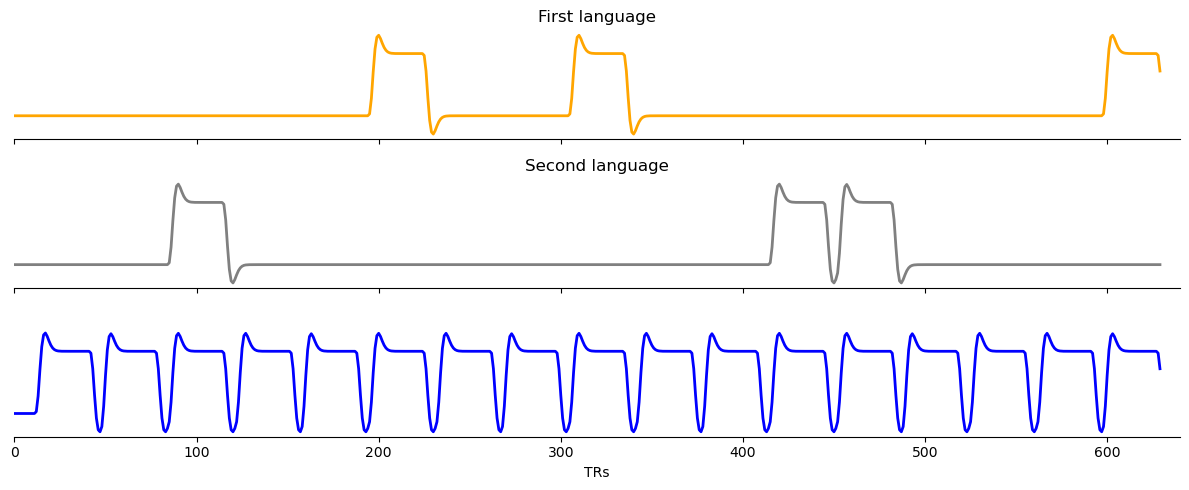

In [36]:
first_lang_stim_conv, second_lang_stim_conv = language_glm_stim(stim_df, 
                                                                "Chinese", 
                                                                "English", 
                                                                tr, n_trs, 
                                                                hrf)

fig, axs = plt.subplots(3, 1, figsize = (12, 5), sharex = True, sharey = True)

axs[0].plot(first_lang_stim_conv, c = "orange", label = first_language, lw = 2)
axs[1].plot(second_lang_stim_conv, c = "gray", label = second_language, lw = 2)
axs[2].plot(stim_conv, c = "blue", label = "all", lw = 2)
axs[0].set_title("First language")
axs[1].set_title("Second language")

# axs[0].legend(loc = "upper left")
# axs[1].legend(loc = "upper left")
# axs[2].legend(loc = "upper left")

axs[2].set_xlabel("TRs")
axs[0].set_xlim(0, 640)

for i in range(3):
    axs[i].set_yticks([])

# sns.despine()
plt.tight_layout()
plt.savefig(os.path.join(fig_path, f"{subject_name}_block_stim_condition.png"), dpi=300)


In [11]:
np.save(os.path.join(main_path, "preprocessed_data/stim_arr.npy"), 
        {'hrf': hrf, 'stim_arr': stim_arr,
         'stim_conv': stim_conv, 
         'eg_first_lang_conv': first_lang_stim_conv,
         'eg_second_lang_conv': second_lang_stim_conv
         })

np.save(os.path.join(main_path, "preprocessed_data/block_time.npy"), 
        {'start': block_start_time,
         'duration': duration,
         })